In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

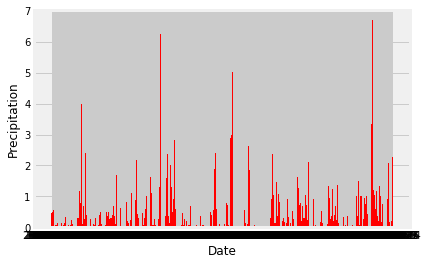

In [73]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>'2016-08-23').order_by(Measurement.date.desc()).all()

test = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>'2016-08-23').order_by(Measurement.date.desc()).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
#df = pd.read_sql_query(session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>'2016-08-23').order_by(Measurement.date.desc()).all()
#, engine)
data = pd.DataFrame(test)
# Sort the dataframe by date
data.sort_values('date')
data.head()
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = data.date
prcp = data.prcp
plt.bar(x_axis, prcp, color='r', align="center")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(zorder=0)

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
first_row = session.query(Station).first()
first_row.__dict__
session.query(Station.id).count()

9

In [13]:
first_row = session.query(Measurement).first()
first_row.__dict__
MeasurementDF= session.query(Measurement.tobs, Measurement.date, Measurement.id, Measurement.prcp, Measurement.station)
measurementdf = pd.DataFrame(MeasurementDF)
measurementdf.head()

,tobs,date,id,prcp,station
0,65.0,2010-01-01,1,0.08,USC00519397
1,63.0,2010-01-02,2,0.00,USC00519397
2,74.0,2010-01-03,3,0.00,USC00519397
3,76.0,2010-01-04,4,0.00,USC00519397
4,73.0,2010-01-06,5,NaN,USC00519397


In [14]:
test2 = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation)
stationdf = pd.DataFrame(test2)
stationdf


,station,name,latitude,longitude,elevation
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

activeStations = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
activeStations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
mostActive=activeStations[0][0]
session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)).\
            filter(Measurement.station == mostActive).all()

[(85.0, 54.0, 71.66378066378067)]

<function matplotlib.pyplot.show(*args, **kw)>

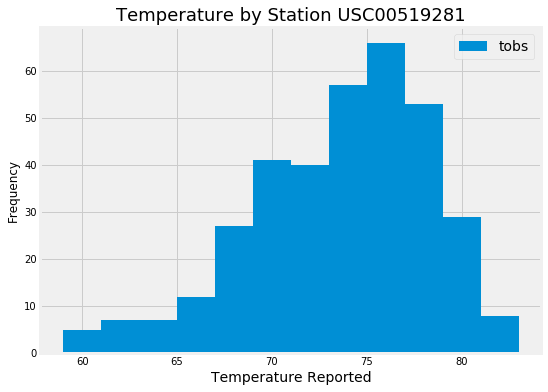

In [70]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
tobs = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == mostActive).\
                filter(Measurement.date>='2016-08-23').all()
tobsdf = pd.DataFrame(tobs)
tobsdf.set_index('station')
tobsdf.head()

#plot the results as a histogram
tobsdf.plot.hist(by='station', bins=12, figsize=(8,6))
plt.grid()
plt.title("Temperature by Station " + mostActive, fontsize=18)
plt.xlabel("Temperature Reported", fontsize=14)
plt.legend(bbox_to_anchor=(1,1), fontsize=14)
plt.grid()
plt.savefig("BestStation.png")
plt.show

![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
